### 1. Configuração do Ambiente e Download do Dataset

In [1]:
# Instala a biblioteca do Kaggle
!pip install kaggle

# Importa a biblioteca para upload de arquivos
from google.colab import files

# Solicita o upload do token da API do Kaggle
print("Faça o upload do seu arquivo 'kaggle.json'")
files.upload()

# Cria o diretório do Kaggle e move o token para lá
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset do Kaggle (pode levar alguns minutos)
print("\nBaixando o dataset 'Road Sign Detection'...")
!kaggle datasets download -d andrewmvd/road-sign-detection

# Descompacta o dataset de forma silenciosa
print("\nDescompactando o dataset...")
!unzip -q road-sign-detection.zip -d ./road_sign_dataset

print("\n--- Ambiente Pronto! ---")

Faça o upload do seu arquivo 'kaggle.json'


Saving kaggle.json to kaggle.json

Baixando o dataset 'Road Sign Detection'...
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 60% 130M/218M [00:00<00:00, 1.36GB/s]
100% 218M/218M [00:00<00:00, 836MB/s] 

Descompactando o dataset...

--- Ambiente Pronto! ---


### 2. Importação das Bibliotecas Principais

In [2]:
# 'os' é usado para interagir com o sistema de arquivos, como ler nomes de arquivos.
import os
# 'pandas' é a principal ferramenta para trabalhar com dados em formato de tabela (DataFrames).
import pandas as pd
# 'xml.etree.ElementTree' é usado para ler os arquivos de anotação que estão no formato XML.
import xml.etree.ElementTree as ET
# 'matplotlib.pyplot' é usado para criar gráficos e visualizações.
import matplotlib.pyplot as plt
# 'cv2' (OpenCV) é uma biblioteca poderosa para manipulação e visualização de imagens.
import cv2
# 'collections.Counter' é uma forma fácil de contar a frequência de itens em uma lista.
from collections import Counter

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


### 3. Definição dos Caminhos (Paths)

In [3]:
# Define o caminho para a pasta que contém os arquivos de anotação (.xml)
annotations_path = 'road_sign_dataset/annotations'

# Define o caminho para a pasta que contém os arquivos de imagem (.png)
images_path = 'road_sign_dataset/images'

# Imprime os caminhos para confirmar que estão corretos
print(f"Caminho das anotações: {annotations_path}")
print(f"Caminho das imagens: {images_path}")

Caminho das anotações: road_sign_dataset/annotations
Caminho das imagens: road_sign_dataset/images


### 4. Extração dos Dados das Anotações (XML)

In [4]:
# 'xml_data' será nossa lista principal para guardar todas as informações que extrairmos.
xml_data = []

# Informa o início do processo de extração.
print("Iniciando a extração dos dados dos arquivos XML...")

# O loop 'for' vai percorrer cada nome de arquivo dentro da pasta de anotações.
for file in os.listdir(annotations_path):
    # Verificamos se o arquivo é um arquivo XML antes de tentar lê-lo.
    if file.endswith('.xml'):
        # Criamos o caminho completo para o arquivo.
        file_path = os.path.join(annotations_path, file)
        # Usamos a biblioteca ET para "parsear" (ler e entender a estrutura) do arquivo XML.
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Encontramos a tag 'filename' no XML, que contém o nome do arquivo da imagem.
        image_name = root.find('filename').text

        # Agora, procuramos por todas as tags 'object'. Cada uma representa um sinal de trânsito na imagem.
        for member in root.findall('object'):
            # Dentro de cada 'object', encontramos a tag 'bndbox', que contém as coordenadas.
            box = member.find('bndbox')
            # E a tag 'name', que contém a classe do sinal.
            label = member.find('name').text

            # Extraímos as coordenadas, convertendo o texto para números inteiros.
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)

            # Adicionamos uma lista com todas as informações extraídas à nossa lista principal 'xml_data'.
            xml_data.append([image_name, label, xmin, ymin, xmax, ymax])

# Ao final, imprimimos uma mensagem de sucesso com o total de anotações encontradas.
print(f"Extração concluída! Foram encontradas {len(xml_data)} anotações de sinais de trânsito.")

Iniciando a extração dos dados dos arquivos XML...
Extração concluída! Foram encontradas 1244 anotações de sinais de trânsito.


### 5. Criação do DataFrame com Pandas

In [5]:
# Define os nomes que daremos para cada coluna da nossa tabela.
column_names = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

# Cria o DataFrame usando a biblioteca Pandas.
# pd.DataFrame() recebe nossa lista de dados e os nomes das colunas.
df = pd.DataFrame(xml_data, columns=column_names)

# Exibe as 5 primeiras linhas do DataFrame para uma verificação rápida.
# .head() é uma das funções mais usadas para inspecionar dados.
print("DataFrame criado com sucesso! Amostra dos dados:")
df.head()

DataFrame criado com sucesso! Amostra dos dados:


,filename,class,xmin,ymin,xmax,ymax
0,road793.png,speedlimit,98,192,145,241
1,road793.png,speedlimit,94,312,107,326
2,road261.png,speedlimit,201,61,236,101
3,road771.png,speedlimit,139,155,176,194
4,road535.png,speedlimit,100,254,180,334


### 6. Análise Exploratória e Visualização da Distribuição

Total de anotações (sinais identificados): 1244
Número de classes (tipos de sinais) únicas: 4

Distribuição das classes (quantos sinais de cada tipo):
class
speedlimit      783
crosswalk       200
trafficlight    170
stop             91
Name: count, dtype: int64


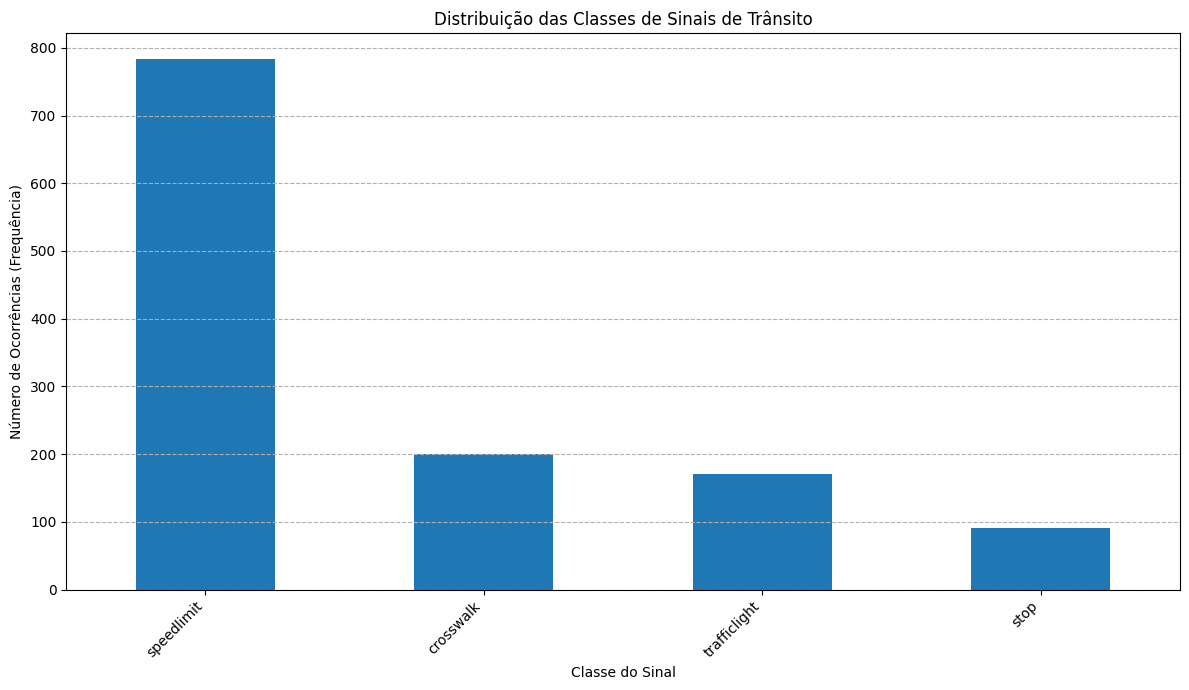

In [6]:
# Imprime o número total de anotações (linhas no DataFrame).
print(f"Total de anotações (sinais identificados): {len(df)}")
# Usa nunique() para contar quantos tipos de sinais únicos existem.
print(f"Número de classes (tipos de sinais) únicas: {df['class'].nunique()}")

# Usa a função value_counts() do Pandas para contar quantas vezes cada classe aparece.
class_counts = df['class'].value_counts()
print("\nDistribuição das classes (quantos sinais de cada tipo):")
print(class_counts)

# --- Visualização ---
# Cria uma figura para o nosso gráfico com um tamanho definido.
plt.figure(figsize=(12, 7))
# Cria o gráfico de barras usando os dados que contamos.
class_counts.plot(kind='bar')
# Define o título e os rótulos dos eixos.
plt.title('Distribuição das Classes de Sinais de Trânsito')
plt.xlabel('Classe do Sinal')
plt.ylabel('Número de Ocorrências (Frequência)')
# Rotaciona os nomes das classes no eixo x para que não fiquem sobrepostos.
plt.xticks(rotation=45, ha='right')
# Adiciona uma grade no eixo y para facilitar a leitura.
plt.grid(axis='y', linestyle='--')
# Ajusta o layout para garantir que nada seja cortado.
plt.tight_layout()
# Exibe o gráfico.
plt.show()

### 7. Visualizar uma Imagem com suas Anotações

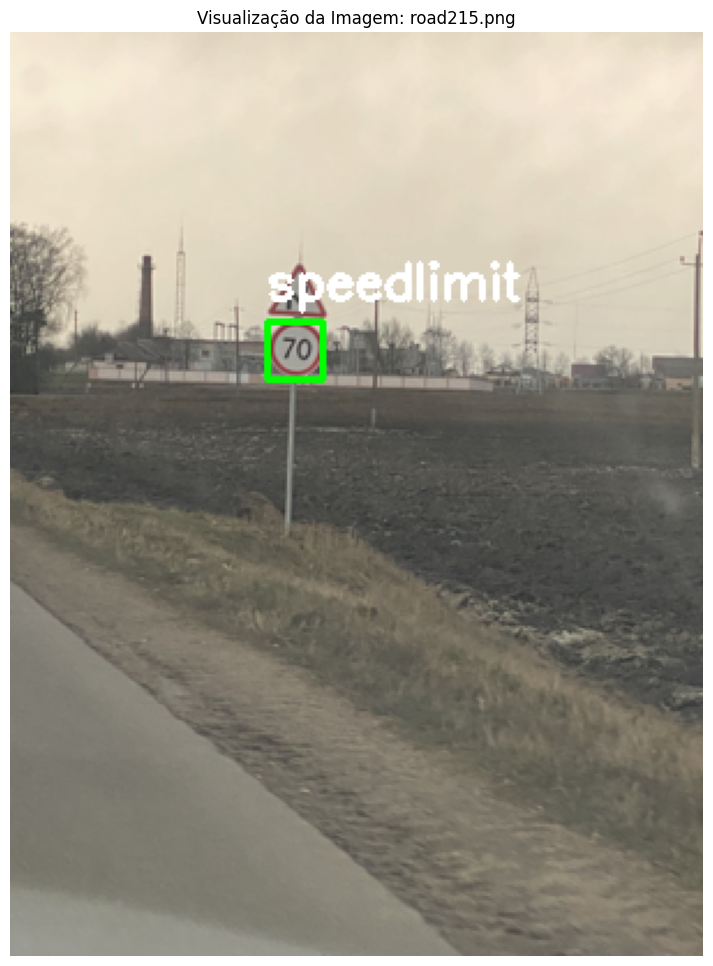

In [7]:
# Pega o nome de um arquivo de imagem aleatório do nosso DataFrame.
# .sample(1) pega uma linha aleatória, .iloc[0] extrai o valor daquela célula.
sample_image_name = df['filename'].sample(1).iloc[0]

# Monta o caminho completo para o arquivo de imagem.
image_path = os.path.join(images_path, sample_image_name)
# Carrega a imagem do disco usando a biblioteca OpenCV.
image = cv2.imread(image_path)
# O OpenCV carrega imagens no formato BGR (Blue, Green, Red).
# O Matplotlib espera RGB, então convertemos a ordem das cores para uma exibição correta.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Filtra o DataFrame para obter todas as anotações (linhas) da imagem selecionada.
annotations = df[df['filename'] == sample_image_name]

# Loop 'for' para desenhar cada bounding box encontrada para esta imagem.
for index, row in annotations.iterrows():
    # Desenha o retângulo na imagem.
    # cv2.rectangle(imagem, ponto_inicial, ponto_final, cor, espessura)
    cv2.rectangle(image, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 2) # Verde, espessura 2

    # Coloca o texto da classe um pouco acima da caixa delimitadora.
    # cv2.putText(imagem, texto, posição, fonte, tamanho, cor, espessura)
    cv2.putText(image, row['class'], (row['xmin'], row['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2) # Branco, espessura 2

# Exibe a imagem final com as anotações desenhadas.
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.title(f'Visualização da Imagem: {sample_image_name}')
plt.axis('off') # Esconde os eixos x e y para uma visualização mais limpa.
plt.show()

### 8. Salvar os Dados Processados para o Próximo Notebook

In [8]:
# Define o nome do ficheiro de saída onde vamos guardar os nossos dados.
output_filename = 'road_signs_annotations.csv'

# Usa a função .to_csv() do Pandas para guardar o DataFrame.
# index=False significa que não queremos guardar o índice do DataFrame no ficheiro.
df.to_csv(output_filename, index=False)

# Imprime uma mensagem de confirmação para sabermos que tudo correu bem.
print(f"DataFrame com as anotações processadas foi guardado com sucesso em: '{output_filename}'")
print("\n--- Fim do Notebook de Análise e Pré-processamento ---")

DataFrame com as anotações processadas foi guardado com sucesso em: 'road_signs_annotations.csv'

--- Fim do Notebook de Análise e Pré-processamento ---
